# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Основные задачи:

1. Открытие файла и изучение основной информации(первые 5 строк таблицы, info, гистограммы всего датасета)
2. Предобработка данных:
  2.1. Аномалии
  2.2. Пропуски
  2.3. Неявные дубликаты
  2.4. Изменение типов данных
3. Добавление в таблицу новых столбцов:
  3.1. цена одного кв.м.
  3.2. день,месяц,год объявления
  3.3. тип этажа
  3.4. расстояние до центра в км.
4. Исследовательский анализ данных:
  4.1. Гистограммы основных параметров
  4.2. как быстро продавались квартиры
  4.3. взаимосвязь факторов
  4.4. Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
  4.5. Как стоимость объектов зависит от расстояния до центра города.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t') 

In [4]:
display(data.head()) # выводим первые 5 строк таблицы

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

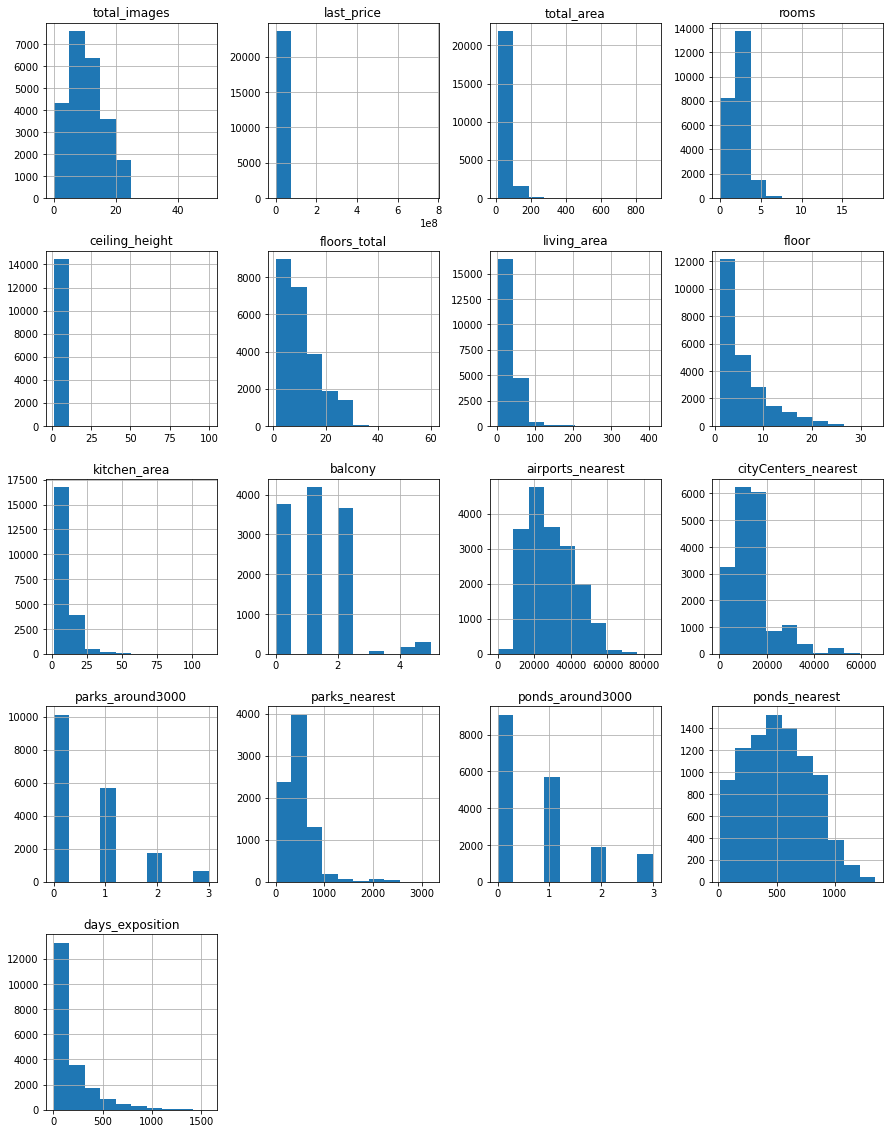

In [5]:
data.hist(figsize=(15, 20)) #изучение основной информации 

### Предобработка данных

In [6]:
data.isna().sum() #к-во пропусков в каждом столбце

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

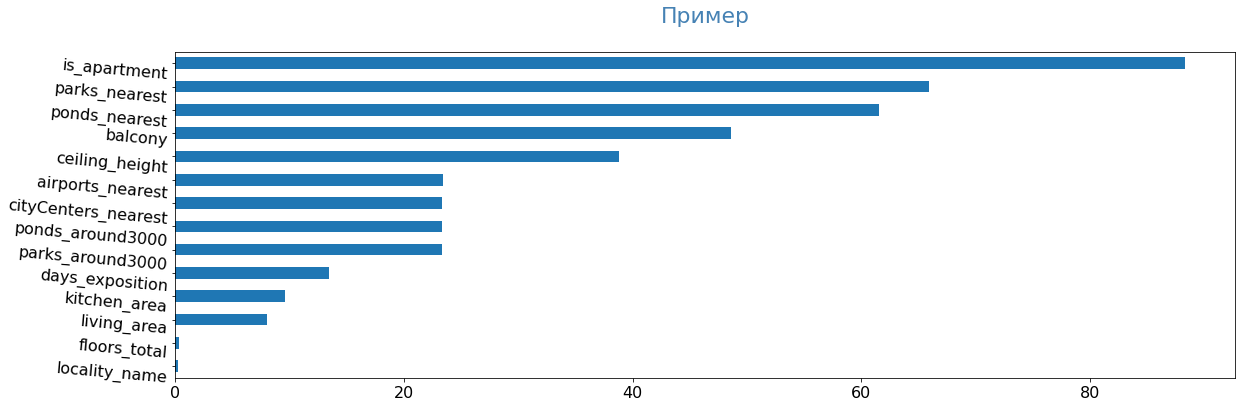

In [8]:
pass_value_barh(data)

In [9]:
data['balcony'] = data['balcony'].fillna(0).astype('int') #заменим пропуски в столбце на 0

In [10]:
#заменим пропуски в столбце ponds_around3000 на 0
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int')
#заменим пропуски в столбце parks_around3000 на 0
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int')


Были заменены пропуски на 0 для количества балконов, дней, парков и озер на 0, потому что скорее всего если их не указали, то значит что их просто нет. Тип данных в этих столбцах был изменен, т.к. такие значения могут быть только целыми.

In [11]:
# заменим в столбце first_day_exposition на формат даты без времени
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

Поскольку везде время было 00:00 решила вовсе изменить формат даты.

In [12]:
#заменим значения площади кухни на 0 для студий
data.loc[(data['studio'] ==1) & (data['kitchen_area'].isna()), 'kitchen_area'] = 0

In [13]:
#заменим пропуски в столбце на False
data['is_apartment'] = data['is_apartment'].fillna(False)

In [14]:
# в столбцах 'airports_nearest', 'parks_nearest', 'ponds_nearest' пропуски замним на 0
columns = ['airports_nearest', 'parks_nearest', 'ponds_nearest']
data[columns] = data[columns].fillna(0)

In [15]:
#устранение неявных дубликатов
data['locality_name']=data['locality_name'].str.replace('посёлок','поселок')
data['locality_name']=data['locality_name'].str.replace('поселок городского типа','поселок')

In [16]:
# check
data['locality_name'].nunique()

329

(0.0, 10.0)

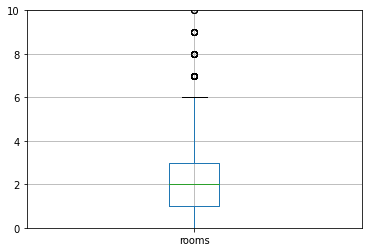

In [17]:
#построим диаграмму размаха для столбца rooms, чтобы посмотреть выбросы
data.boxplot(column='rooms')
plt.ylim(0,10)

(0.0, 10.0)

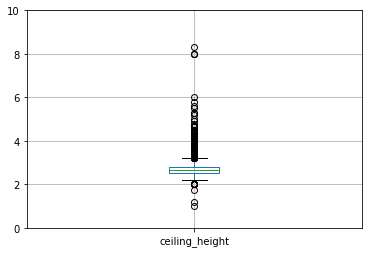

In [18]:
#построим диаграмму размаха для столбца ceiling_height, чтобы посмотреть выбросы
data.boxplot(column='ceiling_height')
plt.ylim(0,10)

In [19]:
#заменим пропуски на 0 и заменим тип столбца на int 
data['floors_total'] = data['floors_total'].fillna(0).astype('int')
data = data[data['floors_total'] != 0]

In [20]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21528 non-null  float64       
 13  balcony         

In [21]:
#удалим ананомальные значения в столбце ceiling_height, но сохраним строки с пропусками
data = data.loc[(data['ceiling_height'] <= 5) & (data['ceiling_height'] >= 2.2)| (data['ceiling_height'].isna())] 

In [22]:
#удалим ананомальные значения в столбце rooms
data = data.loc[(data['rooms'] <= 7) & (data['rooms'] > 0)] 

Посмотрев данные таблицы и диаграмму размаха, можно сделать вывод что квартир  с количеством комнат больше 7 и высотой потолков больше 5 незначительное количество. Поэтому можно их исключить из анализа. А также квартиры с высотой потолков выше 5 метров исключим из анализа.

In [23]:
# check
data.shape

(23340, 22)

In [24]:
#еще раз проверим количество пропусков
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height          8997
floors_total               0
living_area             1854
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area            2013
balcony                    0
locality_name             48
airports_nearest           0
cityCenters_nearest     5414
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3140
dtype: int64

In [25]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

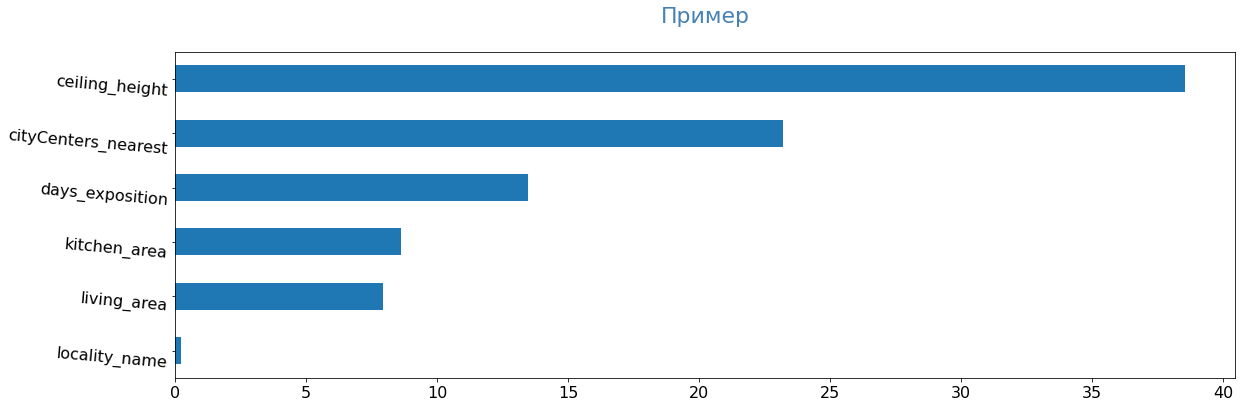

In [26]:
pass_value_barh(data)

In [27]:
#удалим ананомальные значения в столбце total_area, но сохраним строки с пропусками
data = data.loc[(data['total_area'] != 618) & (data['total_area'] >= 20) | (data['total_area'].isna())] 

In [28]:
#удалим ананомальные значения в столбце floors_total, но сохраним строки с пропусками
data = data.loc[(data['floors_total'] <= 30) | (data['floors_total'].isna())] 

In [29]:
#удалим ананомальные значения в столбце living_area, но сохраним строки с пропусками
data = data.loc[(data['living_area'] >= 10) | (data['living_area'].isna())] 

In [30]:
# check
data.shape

(23270, 22)

In [31]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных показателях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,270.00","23,270.00","14,306.00","20,140.00","23,270.00","21,424.00","21,273.00","23,270.00","23,270.00"
min,1.00,20.00,2.20,1.00,"12,190.00",10.00,0.00,1.00,1.00
max,7.00,631.20,5.00,"1,580.00","763,000,000.00",347.50,107.00,27.00,29.00


In [32]:
# check
data.last_price.value_counts().to_frame()

,last_price
4500000.0,341
3500000.0,287
4000000.0,257
4200000.0,257
4300000.0,256
...,...
2228000.0,1
86738800.0,1
10430000.0,1
9917600.0,1


In [33]:
#еще раз проверим количество пропусков
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height          8964
floors_total               0
living_area             1846
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area            1997
balcony                    0
locality_name             48
airports_nearest           0
cityCenters_nearest     5409
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3130
dtype: int64

### Посчитайте и добавьте в таблицу новые столбцы

In [34]:
#цена одного квадратного метра
data['one_square_meter'] = data['last_price'] / data['total_area']


In [35]:
#день недели публикации объявления 
data['week_exposition'] = data['first_day_exposition'].dt.weekday


In [36]:
#месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

In [37]:
#год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

In [38]:
#тип этажа квартиры
def floor_type(row):
    floors = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors:
        return 'последний'
    elif 1 < floor < floors:
        return 'другой'

In [39]:
data['floor_types'] = data.apply(floor_type, axis = 1)

In [40]:
#расстояние до центра города в километрах  
data['km_city_center'] = data['cityCenters_nearest'] / 1000
data['km_city_center'] = data['km_city_center'].round(2)


In [41]:
# check
data['km_city_center']

0        16.03
1        18.60
2        13.93
3         6.80
4         8.10
         ...  
23694     4.23
23695      NaN
23696      NaN
23697    10.36
23698      NaN
Name: km_city_center, Length: 23270, dtype: float64

In [42]:
# check
data['total_images']

0        20
1         7
2        10
3         0
4         2
         ..
23694     9
23695    14
23696    18
23697    13
23698     4
Name: total_images, Length: 23270, dtype: int64

### Проведите исследовательский анализ данных

count    23270.000000
mean        60.269594
std         33.810067
min         20.000000
25%         40.200000
50%         52.000000
75%         70.000000
max        631.200000
Name: total_area, dtype: float64

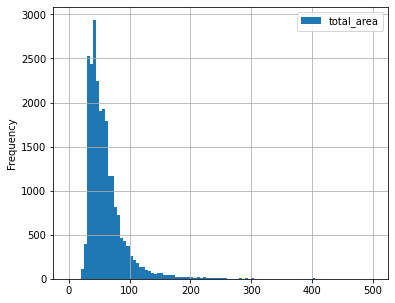

In [43]:
#общая площадь
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (6,5), range = (0,500))
data['total_area'].describe()

Вывод: общая площадь квартиры в среднем составляет от 30 до 100 кв. м. Квартиры с большей и меньшей  площадью скорее исключения.

count    21424.000000
mean        34.394811
std         21.029422
min         10.000000
25%         18.700000
50%         30.000000
75%         42.400000
max        347.500000
Name: living_area, dtype: float64

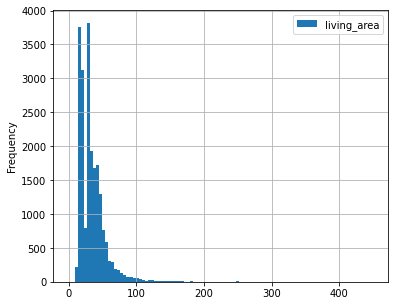

In [44]:
#жилая площадь
data.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (6,5), range = (0,450))
data['living_area'].describe()

Вывод:На гистограмме видно, что жилая площадь составляет не менее 10 кв.м. и не более 150 кв м. 

count    21273.000000
mean        10.518236
std          5.774956
min          0.000000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

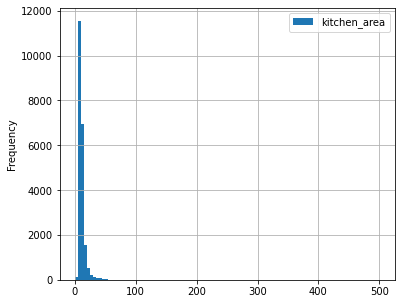

In [45]:
#площадь кухни
data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (6,5), range = (0,500))
data['kitchen_area'].describe()

Вывод: можно сказать, что площадь кухни в среднем не больше 20 кв.м.На гистограмме видно, что квартир с площадью кухни больше 50 кв.м. практически нет.

count    2.327000e+04
mean     6.482996e+06
std      1.019867e+07
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

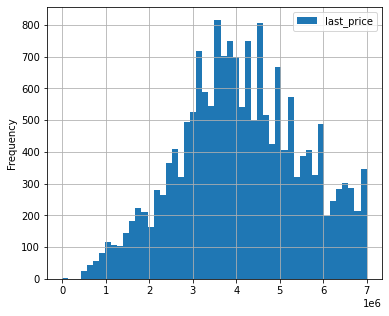

In [46]:
#цена объекта
data.plot(y = 'last_price', kind = 'hist', bins = 50, grid=True, figsize = (6,5), range = (0,7000000))
data['last_price'].describe()

count    23270.000000
mean         2.079115
std          1.021774
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

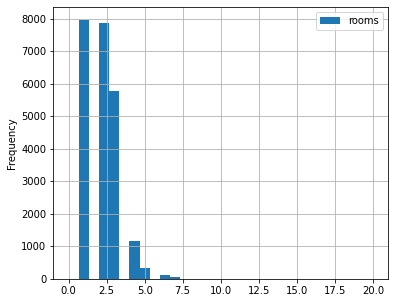

In [47]:
#количество комнат
data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (6,5), range = (0,20))
data['rooms'].describe()

count    14306.000000
mean         2.724875
std          0.270832
min          2.200000
25%          2.510000
50%          2.650000
75%          2.800000
max          5.000000
Name: ceiling_height, dtype: float64

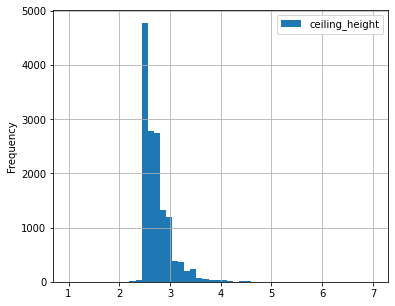

In [48]:
#высота потолков
data.plot(y = 'ceiling_height', kind = 'hist', bins = 50, range = (1,7), grid=True, figsize = (6,5))
data['ceiling_height'].describe()

count    23270.000000
mean         5.844951
std          4.827955
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

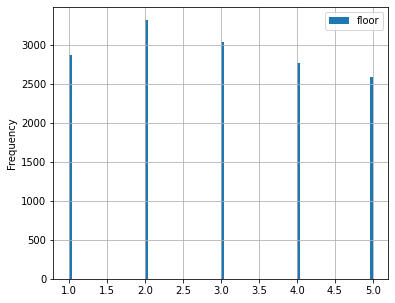

In [49]:
#этаж квартиры 
data.plot(y = 'floor', kind = 'hist', bins = 100, range = (1,5), grid=True, figsize = (6,5))
data['floor'].describe()

Вывод: Можно сказать, что больше всего продается 2-хкомнатных квартир. Скорее всего они считаются оптимальным выбором.Также активно покупаются 3-4 и 1 комнатные квартиры.

<AxesSubplot:>

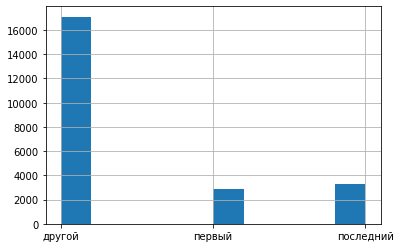

In [50]:
#тип этажа квартиры  
data['floor_types'].hist()

Вывод: Можно сказать что больше всего объявлений квартир, расположенных не на первом и не на последнем этажах.

count    23270.000000
mean        10.601504
std          6.506920
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

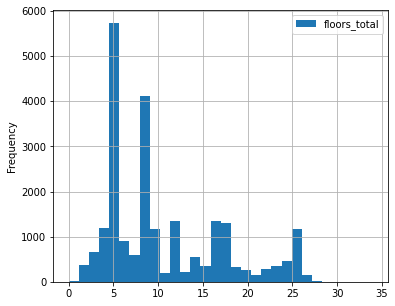

In [51]:
#общее количество этажей в доме 
data.plot(y = 'floors_total', kind = 'hist', bins = 30, range = (0,34), grid=True, figsize = (6,5))
data['floors_total'].describe()

Вывод: Можно сказать что 5 и 9 этажные дома наиболее распространенные. Домов же выше 25 этажа значительно меньше.

count    17861.000000
mean     14200.482672
std       8629.656571
min        181.000000
25%       9238.000000
50%      13092.000000
75%      16275.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

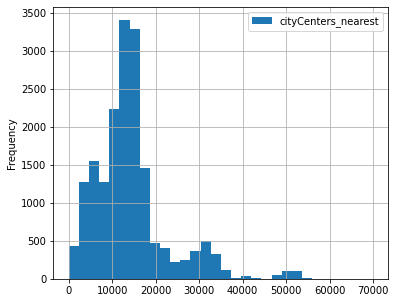

In [52]:
#расстояние до центра города в метрах 
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 30, range = (0,70000), grid=True, figsize = (6,5))
data['cityCenters_nearest'].describe()

Вывод: можно сказать, что больше всего объектов расположенных дальше от центра, скорее всего это связано с высокой ценой на квартиры в центре и низким спросом на них.

count    17837.000000
mean     28845.126310
std      12633.645244
min       6450.000000
25%      18573.000000
50%      26786.000000
75%      37313.000000
max      84869.000000
Name: airports_nearest, dtype: float64

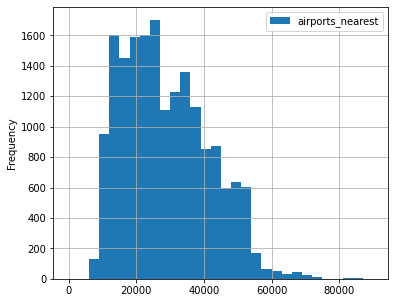

In [53]:
#расстояние до ближайшего аэропорта 
airport_filter = data.query('airports_nearest != 0')
airport_filter.plot(y = 'airports_nearest', kind = 'hist', bins = 30, range = (0,90000), grid=True, figsize = (6,5))
airport_filter['airports_nearest'].describe()

Вывод: Судя по диаграмме можно сделать вывод, что квартиры в целом расположены равномерно далеко от аэропорта. 

count    7953.000000
mean      490.139067
std       341.539950
min         1.000000
25%       287.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

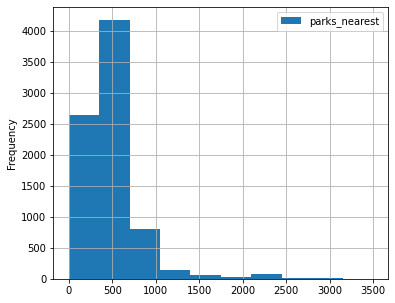

In [54]:
#расстояние до ближайшего парка 
park_filter = data.query('parks_nearest != 0')
park_filter.plot(y = 'parks_nearest', kind = 'hist', bins = 10, range = (0,3500), grid=True, figsize = (6,5))
park_filter['parks_nearest'].describe()

вывод: Можно сказать, что квартир возле парка значительно больше чем на расстоянии от них. Большая часть расположена от 1 до 600 метров.

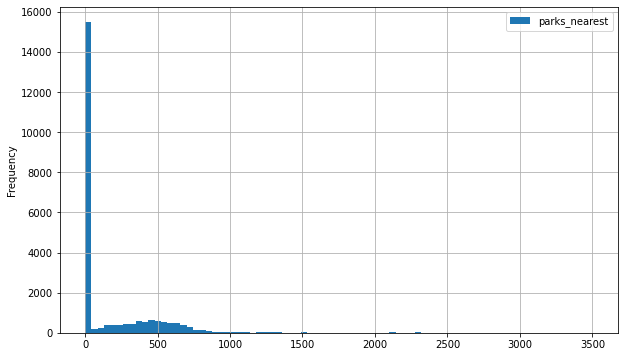

In [55]:
# check

data.plot(y = 'parks_nearest', kind = 'hist', bins = 80, range = (0,3500), grid=True, figsize = (10,6));

count    23270.000000
mean         2.567211
std          1.789570
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: week_exposition, dtype: float64

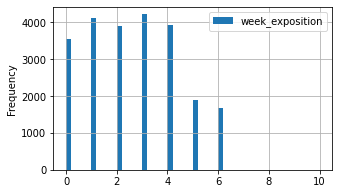

In [56]:
#день публикации объявления
data.plot(y = 'week_exposition', kind = 'hist', bins = 50, range = (0,10), grid=True, figsize = (5,3))
data['week_exposition'].describe()

Вывод: в целом количество объявлений довольно равномерно по дням, единственное что ближе к 6 дню можно заметить небольшой спад. 

count    23270.000000
mean         6.395875
std          3.491296
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

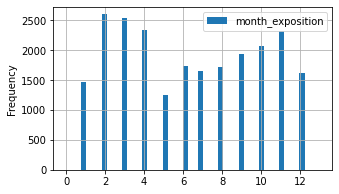

In [57]:
#месяц публикации объявления
data.plot(y = 'month_exposition', kind = 'hist', bins = 50, range = (0,13), grid=True, figsize = (5,3))
data['month_exposition'].describe()

Вывод: Можно заметить небольшой спад в мае изначительный рост в феврале и марте.

# example 1

#### как быстро продавались квартиры

count    20140.000000
mean       181.372244
std        219.925883
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

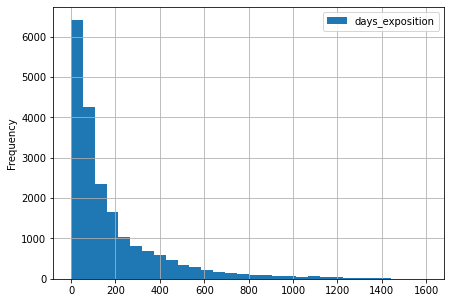

In [58]:
#как быстро продавались квартиры
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, range = (0,1600), grid=True, figsize = (7,5))
data['days_exposition'].describe()

Из описания видно, что среднее составляет 181 день, а медиана 96 дней. 

<AxesSubplot:>

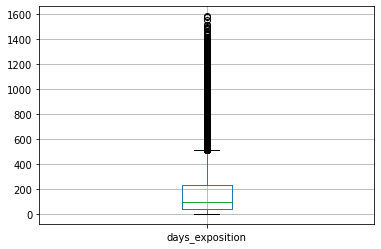

In [59]:
data.boxplot(column='days_exposition')
#plt.ylim(0,10)

In [60]:
data['days_exposition'].value_counts() 

45.0      865
60.0      533
7.0       223
30.0      201
90.0      198
         ... 
818.0       1
1.0         1
969.0       1
1147.0      1
1174.0      1
Name: days_exposition, Length: 1137, dtype: int64

Можно заметить огромное количество объявлений в 45,60,7 и 30 дней. 

In [61]:
#Создадим отдельный датасет, чтобы убрать аномалии и расчитать реальную скорость продаж
filter_data = data.query('days_exposition != 45 and days_exposition != 30 and days_exposition != 60 and days_exposition != 7 and days_exposition != 0')

count    19183.000000
mean       188.357713
std        222.999458
min          1.000000
25%         45.000000
50%        104.000000
75%        245.000000
max       1580.000000
Name: days_exposition, dtype: float64

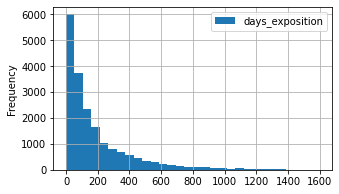

In [62]:
filter_data.plot(y = 'days_exposition', kind = 'hist', bins = 30, range = (0,1600), grid=True, figsize = (5,3))
filter_data['days_exposition'].describe()

вывод: после избавления от аномальных значений медиана стала 104, а среднее значение 188.Можно сказать что быстрая продажа может быть от 1 до 104-188 дней, а необычно долгие продажи могут быть до 1580 дней.

#####  Какие факторы больше всего влияют на общую стоимость объекта

In [63]:
#зависимость цены и общей площади квартиры
total_square = data.pivot_table(index='total_area', values='last_price', aggfunc=['count','sum','mean']) 
total_square.columns=['Количество', 'Сумма', 'Среднее']
display(total_square)

,Количество,Сумма,Среднее
total_area,,,
20.00,6,13105000.0,2.184167e+06
20.10,1,2150000.0,2.150000e+06
20.30,1,2740000.0,2.740000e+06
20.60,1,2000000.0,2.000000e+06
20.67,2,3711250.0,1.855625e+06
...,...,...,...
500.00,2,380000000.0,1.900000e+08
507.00,1,84000000.0,8.400000e+07
517.00,1,50000000.0,5.000000e+07


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

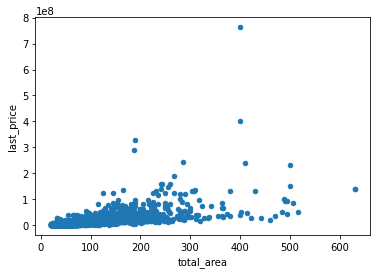

In [64]:
colors=["blue","green"]
data.plot(x='total_area', y='last_price', kind='scatter')


In [65]:
print('Коэффициент корреляции:', data['total_area'].corr(data['last_price']))

Коэффициент корреляции: 0.6343120607410506


Вывод: Исходя из графика и корреляции, можно судить об умеренной взаимосвязи между ценой и общей площадью квартиры.Можно сказать, что квартиры с площадью до 100-200 кв м покупают наиболее часто.

In [66]:
#зависимость цены и жилой площади квартиры
living_square = data.pivot_table(index='living_area', values='last_price', aggfunc=['count','sum','mean']) 
living_square.columns=['Количество', 'Сумма', 'Среднее']
display(living_square.head(10))

,Количество,Сумма,Среднее
living_area,,,
10.00,27,97754297.0,3.620530e+06
10.08,2,6500000.0,3.250000e+06
10.30,2,12100000.0,6.050000e+06
10.40,3,11825000.0,3.941667e+06
10.50,3,24200000.0,8.066667e+06
10.52,1,3797250.0,3.797250e+06
10.55,1,2000000.0,2.000000e+06
10.60,2,9520000.0,4.760000e+06
10.70,2,10410136.0,5.205068e+06


<AxesSubplot:xlabel='living_area', ylabel='last_price'>

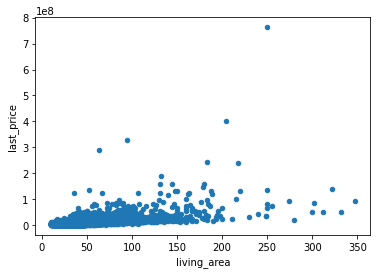

In [67]:
data.plot(x='living_area', y='last_price', kind='scatter')

In [68]:
print('Коэффициент корреляции:', data['living_area'].corr(data['last_price']))

Коэффициент корреляции: 0.5475750720551805


Вывод: Исходя из графика и корреляции, можно судить об умеренной взаимосвязи между ценой и жилой площадью квартиры. Однако все равно можно сказать, что квартиры с жилой площадью от 30 до 100 покупаются более охотно.

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

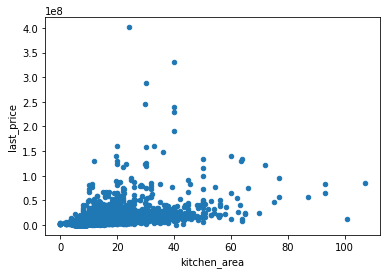

In [69]:
#зависимость цены и площади кухни
data.plot(x='kitchen_area', y='last_price', kind='scatter')

In [70]:
print('Коэффициент корреляции:', data['kitchen_area'].corr(data['last_price']))

Коэффициент корреляции: 0.5038512175512703


Вывод: Можно судить об умеренной связи между площадью кухни и ценой квартиры.

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

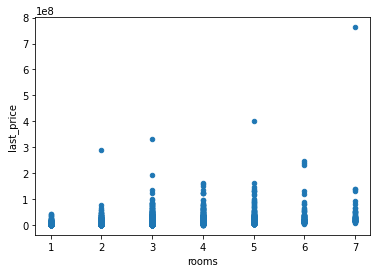

In [71]:
#зависимость цены и количества комнат
data.plot(x='rooms', y='last_price', kind='scatter')

In [72]:
print('Коэффициент корреляции:', data['rooms'].corr(data['last_price']))

Коэффициент корреляции: 0.3515872855959396


Вывод: также можно говорить об умеренной связи между количеством комнат и ценой квартиры. Можно сказать, что самые дорогие квартиры это 4-5 комнат, а самые дешевые это однушки.

<AxesSubplot:xlabel='floor_types'>

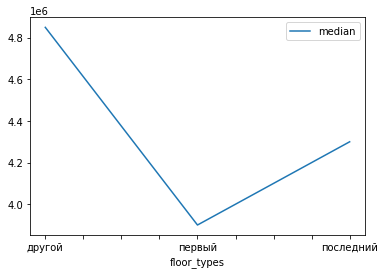

In [73]:
#зависимость цены и типа этажа
#data.plot(x='floor_types', y='last_price', kind='scatter')
types_floor = data.pivot_table(index = 'floor_types', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
types_floor.columns = ['mean', 'count', 'median']
types_floor.plot(y = 'median')

Вывод: исходя из графика можно сделать вывод, что квартиры на первом этаже значительно дешевле квартир на любом другом этаже. Можно также сказать, что в большинстве своем выбирают не первый и не последний этаж, что объяснимо небольшими сложностями в проживании на них. Также на сайтах по недвижимости даже есть фильтр исключащий эти квартиры.

<AxesSubplot:xlabel='week_exposition', ylabel='last_price'>

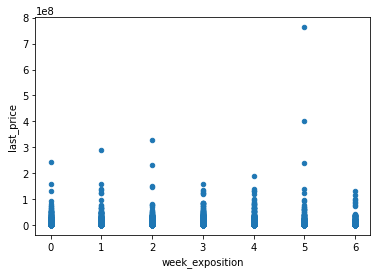

In [74]:
#зависимость цены и дня размещения
data.plot(x='week_exposition', y='last_price', kind='scatter')

Вывод: связи между днем публикации объявления и ценой квартиры не обнаружено.

<AxesSubplot:xlabel='month_exposition', ylabel='last_price'>

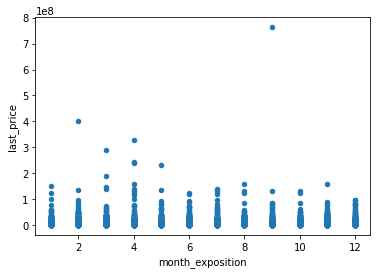

In [75]:
#зависимость цены и месяца размещения
data.plot(x='month_exposition', y='last_price', kind='scatter')

In [76]:
print('Коэффициент корреляции:', data['month_exposition'].corr(data['last_price']))

Коэффициент корреляции: -0.000542937068974941


Вывод: связи между месяцем публикации объявления и ценой квартиры не обнаружено.

,mean,count,median
year_exposition,,,
2014,1.208714e+07,137,7700000.0
2015,8.290106e+06,1168,5300500.0
2019,6.744561e+06,2833,5099000.0
2018,5.943448e+06,8364,4600000.0
2016,6.799361e+06,2748,4500000.0
2017,6.485980e+06,8020,4500000.0


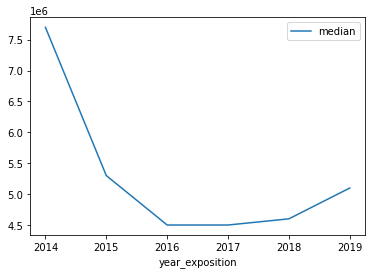

In [77]:
#зависимость цены и года размещения
#data.plot(x='year_exposition', y='last_price', kind='scatter')
year_exposition = data.pivot_table(index = 'year_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
year_exposition.columns = ['mean', 'count', 'median']
year_exposition.plot(y = 'median')

year_exposition.sort_values('median', ascending = False)

Вывод: Можно заметить, что по сравнению с 2014-2015 годами произошел спад к 2016-2017 годам. Однако в 2014-2015 годах количество объявлений было небольшим, а цена высокой. Можно заметить, что в 2017-2018 года к-во объявлений значительно выросло, а цена оставалась примерно такой же. В 2019 году мы можем наблюдать падение к-ва объявлений и рост цены.

In [78]:
#Среднюю цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
ave_price_one_m2 = data.pivot_table(index = 'locality_name', values = 'one_square_meter', aggfunc=['count', 'mean'])
ave_price_one_m2.columns = ['count', 'mean']
ave_price_one_m2['mean'] = ave_price_one_m2['mean'].round(2)
ave_price_one_m2 = ave_price_one_m2.sort_values('count', ascending = False)
ave_price_one_m2 = ave_price_one_m2[:10]
display(ave_price_one_m2)

,count,mean
locality_name,,
Санкт-Петербург,15424,114560.98
поселок Мурино,525,85066.69
поселок Шушары,434,78303.21
Всеволожск,391,68683.76
Пушкин,368,103081.15
Колпино,337,75333.30
поселок Парголово,323,90289.78
Гатчина,306,68757.68
деревня Кудрово,283,92297.22


In [79]:
#самая высокая стоимость
ave_price_one_m2[ave_price_one_m2['mean']==ave_price_one_m2['mean'].max()]


,count,mean
locality_name,,
Санкт-Петербург,15424,114560.98


In [80]:
#самая низкая стоимость
ave_price_one_m2[ave_price_one_m2['mean']==ave_price_one_m2['mean'].min()]

,count,mean
locality_name,,
Выборг,235,58238.14


<AxesSubplot:xlabel='locality_name'>

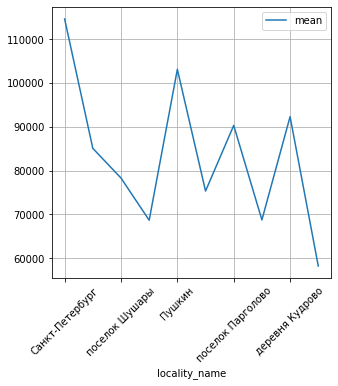

In [81]:
ave_price_one_m2.plot(y = 'mean', grid=True, rot=45, figsize=(5,5))

Вывод: Были отобраны 10 населенных пунктов с наибольшим количеством объявлений. Исходя из них можно сделать вывод, что наиболее высокая цена за квадратный метр в Санкт-Петербурге, а наиболее низкая в Выборге.

In [82]:
#Средняя цена каждого километра
data['km_city_center'] = data['km_city_center'].fillna(-1) #заменим пропуски на -1
ave_price_km1 = data.query('locality_name == "Санкт-Петербург" and km_city_center !=-1')\
.groupby('km_city_center')['one_square_meter'].mean()
display(ave_price_km1.head(10))

km_city_center
0.18    195591.194969
0.21    172619.047619
0.22    109900.000000
0.29     95058.941100
0.32    423999.623668
0.33    100000.000000
0.38    137755.102041
0.39    169833.658752
0.40    122764.976959
0.41     75471.698113
Name: one_square_meter, dtype: float64

<AxesSubplot:xlabel='km_city_center'>

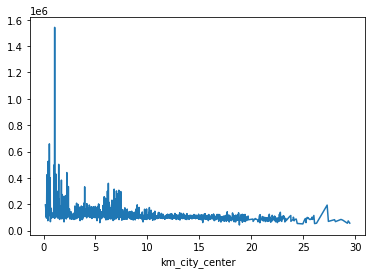

In [83]:
ave_price_km1.plot(x='km_city_center', y='one_square_meter')

Вывод:Судя по графику можем видеть, что наиболее высокие цены на квартиры можно наблюдать в центре города.

### Общий вывод

Вывод: В ходе работы над проектом удалось заменить в некоторых столбцах пропущенные значения, а также определить различные статистические выбросы. 
Удалось выявить взаимосвязь между общей площадью квартиры и ее стоимостью.Было замечено, что несмотря на спад начиная с 2014-2015 годов, на них ориентироваться нельзя, потому что объявлений достаточно мало, а цены высокие. Наиболее стабильными можно назвать 2017-2018 года, где к-во объявлений и цена неизменились. В 2019 заметен рост цен, но и уменьшение к-ва объявлений. Связи между днем, месяцем и ценой не было выявлено. 
Я расчитала среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений, отсюда удалось выявить самую высокую стоимость - Санкт-Петербург(114 560,98), самую низкую стоимость - Выборг(58 238,14).  
Была расчитана средняя цена каждого километра, где мы узнали что действительно квартиры в центре стоят дороже чем за его пределами.Наиболее дорогие квартиры расположены в 1-8 км от центра. 
Было выявлено, что цена на квартиры не на первом и не на последнем этажах выше,что вполне объяснимо небольшими неудобствами проживания на первом и последнем этажах.
Можно заметить также рост цен на квартиры с соотвествующим ростом общей и жилой площади квартиры, однако у них тоже есть предел. Общая площадь квартиры не должна привышать 200 кв м, а жилая площадь не должна быть выше 130 кв м. 
Можно сказать, что больше всего продается 2-хкомнатных квартир. Скорее всего они считаются оптимальным выбором.Также активно покупаются 3-4 и 1 комнатные квартиры. В тоже время самыми распространенными считают 5 и 9 этажные дома.
